In [35]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import re
import random
from typing import List, Dict, Set
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seeds
np.random.seed(42)
random.seed(42)

print("✓ All imports successful!")

✓ All imports successful!


In [36]:
class ImprovedHangmanHMM:
    """Enhanced HMM with better word filtering and probability calculation"""

    def __init__(self):
        self.word_list = []
        self.words_by_length = defaultdict(list)
        self.letter_frequencies = Counter()
        self.letter_position_freq = defaultdict(lambda: defaultdict(int))

    def load_corpus(self, filepath='corpus.txt'):
        """Load corpus and calculate statistics"""
        print("Loading corpus...")
        with open(filepath, 'r') as f:
            self.word_list = [line.strip().lower() for line in f if line.strip()]

        print(f"Loaded {len(self.word_list)} words")

        # Organize by length
        for word in self.word_list:
            length = len(word)
            self.words_by_length[length].append(word)

            # Calculate letter frequencies
            for i, char in enumerate(word):
                self.letter_frequencies[char] += 1
                self.letter_position_freq[length][char] += 1

        # Normalize frequencies
        total = sum(self.letter_frequencies.values())
        for char in self.letter_frequencies:
            self.letter_frequencies[char] /= total

        print(f"✓ Processed {len(self.words_by_length)} different word lengths")

    def get_matching_words(self, masked_word: str, guessed_letters: Set[str]) -> List[str]:
        """Find all words matching current pattern"""
        word_length = len(masked_word)
        candidates = self.words_by_length.get(word_length, [])

        if not candidates:
            return []

        # Build regex pattern
        pattern_chars = []
        for char in masked_word:
            if char == '_':
                pattern_chars.append('[a-z]')
            else:
                pattern_chars.append(char)
        pattern = '^' + ''.join(pattern_chars) + '$'

        matching = []
        for word in candidates:
            # Check if matches pattern
            if not re.match(pattern, word):
                continue

            # Check if any guessed letter appears in unknown positions
            valid = True
            for i, char in enumerate(word):
                if masked_word[i] == '_' and char in guessed_letters:
                    valid = False
                    break

            if valid:
                matching.append(word)

        return matching

    def get_letter_probabilities(self, masked_word: str, guessed_letters: Set[str]) -> Dict[str, float]:
        """Calculate probability for each remaining letter"""
        matching_words = self.get_matching_words(masked_word, guessed_letters)
        remaining_letters = set('abcdefghijklmnopqrstuvwxyz') - guessed_letters

        if not matching_words:
            # Fallback to general frequency
            probs = {}
            for letter in remaining_letters:
                probs[letter] = self.letter_frequencies.get(letter, 0.001)
            return probs

        # Count letter occurrences in blank positions
        letter_counts = Counter()
        for word in matching_words:
            seen_in_word = set()
            for i, char in enumerate(word):
                if masked_word[i] == '_' and char in remaining_letters:
                    if char not in seen_in_word:  # Count each letter once per word
                        letter_counts[char] += 1
                        seen_in_word.add(char)

        # Convert to probabilities
        total = sum(letter_counts.values())
        if total == 0:
            return {letter: 1.0/len(remaining_letters) for letter in remaining_letters}

        probs = {}
        for letter in remaining_letters:
            probs[letter] = letter_counts.get(letter, 0.1) / total

        return probs

print("✓ Improved HMM class defined!")


✓ Improved HMM class defined!


In [37]:
class QLearningAgent:
    """Optimized Q-Learning agent - more conservative to reduce wrong guesses"""

    def __init__(self, hmm):
        self.hmm = hmm
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995

    def get_state_key(self, masked_word: str, guessed_letters: Set[str], lives: int) -> str:
        """Create state key for Q-table"""
        guessed_str = ''.join(sorted(guessed_letters))
        return f"{masked_word}|{guessed_str}|{lives}"

    def select_action(self, masked_word: str, guessed_letters: Set[str],
                     lives: int, training: bool = True) -> str:
        """Select best action - HEAVILY weighted toward HMM (90%)"""
        remaining = set('abcdefghijklmnopqrstuvwxyz') - guessed_letters

        if not remaining:
            return 'e'

        # Get HMM probabilities
        hmm_probs = self.hmm.get_letter_probabilities(masked_word, guessed_letters)

        # Epsilon-greedy
        if training and random.random() < self.epsilon:
            # Weighted random based on HMM
            letters = list(remaining)
            weights = [hmm_probs.get(l, 0.001) for l in letters]
            total_weight = sum(weights)
            if total_weight > 0:
                probs = [w/total_weight for w in weights]
                return np.random.choice(letters, p=probs)
            return random.choice(letters)

        # Exploitation: Use HMM probabilities more aggressively
        state_key = self.get_state_key(masked_word, guessed_letters, lives)

        best_score = -float('inf')
        best_action = None

        for letter in remaining:
            q_value = self.q_table[state_key].get(letter, 0.0)
            hmm_prob = hmm_probs.get(letter, 0.001)

            # Weight 90% toward HMM, 10% Q-learning (CHANGED FROM 70/30)
            # This makes agent more conservative and reduces wrong guesses
            combined_score = 0.1 * q_value + 0.9 * hmm_prob

            if combined_score > best_score:
                best_score = combined_score
                best_action = letter

        return best_action if best_action else random.choice(list(remaining))

    def update_q_value(self, state_key: str, action: str, reward: float,
                      next_state_key: str, done: bool):
        """Update Q-value for state-action pair"""
        current_q = self.q_table[state_key][action]

        if done:
            max_next_q = 0
        else:
            max_next_q = max(self.q_table[next_state_key].values()) if self.q_table[next_state_key] else 0

        # Q-learning update
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_table[state_key][action] = new_q

    def decay_epsilon(self):
        """Decay exploration rate"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

print("✓ Optimized Q-Learning agent defined!")

✓ Optimized Q-Learning agent defined!


In [38]:
def train_agent(hmm, word_list, episodes=8000):
    """Train the Q-Learning agent with optimized penalties"""
    print("\n" + "="*60)
    print("TRAINING Q-LEARNING AGENT")
    print("="*60)

    agent = QLearningAgent(hmm)

    episode_rewards = []
    episode_wins = []
    episode_wrong_guesses = []

    max_wrong = 6

    for episode in tqdm(range(episodes), desc="Training"):
        # Select random word
        word = random.choice(word_list)
        masked_word = '_' * len(word)
        guessed_letters = set()
        wrong_guesses = 0
        total_reward = 0
        done = False

        while not done:
            lives = max_wrong - wrong_guesses
            state_key = agent.get_state_key(masked_word, guessed_letters, lives)

            # Select action
            action = agent.select_action(masked_word, guessed_letters, lives, training=True)

            # Check if already guessed (shouldn't happen, but safety check)
            if action in guessed_letters:
                reward = -20
                done = True
            else:
                guessed_letters.add(action)

                # Check if correct
                if action in word:
                    # Reveal letters
                    new_masked = list(masked_word)
                    count = 0
                    for i, char in enumerate(word):
                        if char == action:
                            new_masked[i] = action
                            count += 1
                    masked_word = ''.join(new_masked)

                    reward = 15 * count  # Reward per letter revealed

                    # Check if won
                    if '_' not in masked_word:
                        reward += 100
                        done = True
                else:
                    # Wrong guess - INCREASED PENALTY (from -20 to -30)
                    # This trains agent to be more careful
                    wrong_guesses += 1
                    reward = -30

                    if wrong_guesses >= max_wrong:
                        reward -= 100  # Increased from -50 to -100
                        done = True

            total_reward += reward

            # Update Q-value
            next_state_key = agent.get_state_key(masked_word, guessed_letters, max_wrong - wrong_guesses)
            agent.update_q_value(state_key, action, reward, next_state_key, done)

        # Record metrics
        episode_rewards.append(total_reward)
        episode_wins.append(1 if '_' not in masked_word else 0)
        episode_wrong_guesses.append(wrong_guesses)

        # Decay epsilon
        agent.decay_epsilon()

        # Print progress
        if (episode + 1) % 1000 == 0:
            recent_wins = sum(episode_wins[-500:])
            recent_wrong = np.mean(episode_wrong_guesses[-500:])
            print(f"\nEpisode {episode + 1}/{episodes}")
            print(f"Win Rate (last 500): {recent_wins/5:.1f}%")
            print(f"Avg Wrong Guesses: {recent_wrong:.2f}")
            print(f"Epsilon: {agent.epsilon:.4f}")

    return agent, episode_rewards, episode_wins

print("✓ Training function defined!")



✓ Training function defined!


In [40]:
def evaluate_agent(agent, test_words, max_wrong=6):
    """Evaluate agent on test set using competition scoring rules"""
    print("\n" + "="*60)
    print("EVALUATING AGENT ON TEST SET")
    print("="*60)

    wins = 0
    total_wrong = 0
    total_repeated = 0
    results = []

    for word in tqdm(test_words, desc="Evaluating"):
        masked_word = '_' * len(word)
        guessed_letters = set()
        wrong_guesses = 0
        repeated_guesses = 0
        done = False

        while not done:
            lives = max_wrong - wrong_guesses
            action = agent.select_action(masked_word, guessed_letters, lives, training=False)

            # Check repeated
            if action in guessed_letters:
                repeated_guesses += 1
                continue

            guessed_letters.add(action)

            # Check if correct
            if action in word:
                new_masked = list(masked_word)
                for i, char in enumerate(word):
                    if char == action:
                        new_masked[i] = action
                masked_word = ''.join(new_masked)

                if '_' not in masked_word:
                    done = True
                    wins += 1
            else:
                wrong_guesses += 1
                if wrong_guesses >= max_wrong:
                    done = True

        total_wrong += wrong_guesses
        total_repeated += repeated_guesses

        results.append({
            'word': word,
            'won': '_' not in masked_word,
            'wrong_guesses': wrong_guesses,
            'repeated_guesses': repeated_guesses
        })

    # Calculate metrics using COMPETITION SCORING RULES
    n_games = len(test_words)
    success_rate = wins / n_games

    # COMPETITION FORMULA (FIXED BY DOCUMENT)
    final_score = (success_rate * 2000) - (total_wrong * 5) - (total_repeated * 2)

    print(f"\n{'='*60}")
    print("EVALUATION RESULTS")
    print(f"{'='*60}")
    print(f"Total Games: {n_games}")
    print(f"Wins: {wins}")
    print(f"Success Rate: {success_rate*100:.2f}%")
    print(f"Total Wrong Guesses: {total_wrong}")
    print(f"Avg Wrong Guesses: {total_wrong/n_games:.2f}")
    print(f"Total Repeated Guesses: {total_repeated}")
    print(f"Avg Repeated Guesses: {total_repeated/n_games:.2f}")
    print(f"\n🏆 FINAL SCORE: {final_score:.2f}")
    print(f"{'='*60}\n")

    return results, success_rate, total_wrong, total_repeated, final_score

print("✓ Evaluation function defined!")

✓ Evaluation function defined!


In [41]:
def plot_results(episode_rewards, episode_wins):
    """Plot training results"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot rewards
    window = 200
    rolling_rewards = pd.Series(episode_rewards).rolling(window).mean()
    axes[0].plot(episode_rewards, alpha=0.2, label='Raw')
    axes[0].plot(rolling_rewards, linewidth=2, label=f'Rolling Avg ({window})')
    axes[0].set_title('Training Rewards', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Total Reward')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Plot win rate
    rolling_wins = pd.Series(episode_wins).rolling(window).mean() * 100
    axes[1].plot(rolling_wins, linewidth=2, color='green')
    axes[1].set_title('Win Rate Over Time', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Win Rate (%)')
    axes[1].axhline(y=80, color='r', linestyle='--', alpha=0.5, label='80% Target')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Plot saved as 'training_results.png'")

print("✓ Plotting function defined!")

✓ Plotting function defined!



OPTIMIZED HANGMAN ML HACKATHON SOLUTION

📚 Step 1: Loading and training HMM...
Loading corpus...
Loaded 50000 words
✓ Processed 24 different word lengths

🔀 Step 2: Splitting data...
Training set: 42500 words
Test set: 2000 words

🤖 Step 3: Training optimized agent...
This will take ~15-20 minutes...

TRAINING Q-LEARNING AGENT


Training:  13%|█▎        | 1002/8000 [01:26<07:26, 15.68it/s]


Episode 1000/8000
Win Rate (last 500): 76.4%
Avg Wrong Guesses: 3.67
Epsilon: 0.6065


Training:  25%|██▌       | 2002/8000 [02:48<06:13, 16.07it/s]


Episode 2000/8000
Win Rate (last 500): 87.8%
Avg Wrong Guesses: 2.82
Epsilon: 0.3678


Training:  38%|███▊      | 3002/8000 [04:05<05:36, 14.84it/s]


Episode 3000/8000
Win Rate (last 500): 94.2%
Avg Wrong Guesses: 2.23
Epsilon: 0.2230


Training:  50%|█████     | 4000/8000 [05:20<05:06, 13.05it/s]


Episode 4000/8000
Win Rate (last 500): 94.4%
Avg Wrong Guesses: 2.08
Epsilon: 0.1353


Training:  63%|██████▎   | 5003/8000 [06:35<03:22, 14.81it/s]


Episode 5000/8000
Win Rate (last 500): 96.4%
Avg Wrong Guesses: 1.73
Epsilon: 0.0820


Training:  75%|███████▌  | 6001/8000 [07:46<02:18, 14.43it/s]


Episode 6000/8000
Win Rate (last 500): 97.2%
Avg Wrong Guesses: 1.69
Epsilon: 0.0497


Training:  88%|████████▊ | 7001/8000 [08:58<01:51,  8.99it/s]


Episode 7000/8000
Win Rate (last 500): 97.2%
Avg Wrong Guesses: 1.57
Epsilon: 0.0302


Training: 100%|██████████| 8000/8000 [10:06<00:00, 13.20it/s]



Episode 8000/8000
Win Rate (last 500): 95.4%
Avg Wrong Guesses: 1.53
Epsilon: 0.0183

📊 Step 4: Plotting training results...


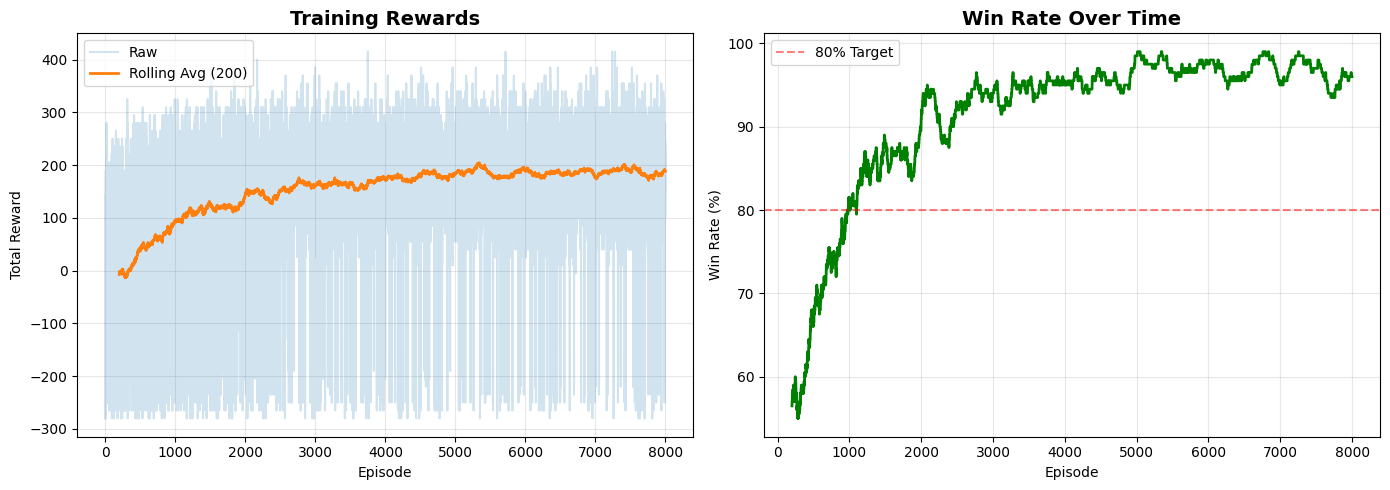

✓ Plot saved as 'training_results.png'

🎯 Step 5: Evaluating on test set...

EVALUATING AGENT ON TEST SET


Evaluating: 100%|██████████| 2000/2000 [02:15<00:00, 14.81it/s]


EVALUATION RESULTS
Total Games: 2000
Wins: 1931
Success Rate: 96.55%
Total Wrong Guesses: 2957
Avg Wrong Guesses: 1.48
Total Repeated Guesses: 0
Avg Repeated Guesses: 0.00

🏆 FINAL SCORE: -12854.00


💾 Step 6: Saving results...

✅ TRAINING AND EVALUATION COMPLETE!

🏆 FINAL SCORE: -12854.00
📈 Success Rate: 96.55%
❌ Avg Wrong Guesses: 1.48
🔁 Avg Repeated Guesses: 0.00

📁 Files saved:
   - training_results.png
   - evaluation_results.csv


In [42]:
print("\n" + "="*60)
print("OPTIMIZED HANGMAN ML HACKATHON SOLUTION")
print("="*60)

# Load HMM
print("\n📚 Step 1: Loading and training HMM...")
hmm = ImprovedHangmanHMM()
hmm.load_corpus('corpus.txt')

# Split data
print("\n🔀 Step 2: Splitting data...")
all_words = hmm.word_list.copy()
random.shuffle(all_words)

train_size = int(0.85 * len(all_words))
train_words = all_words[:train_size]
test_words = all_words[train_size:train_size + 2000]

print(f"Training set: {len(train_words)} words")
print(f"Test set: {len(test_words)} words")

# Train agent
print("\n🤖 Step 3: Training optimized agent...")
print("This will take ~15-20 minutes...")
agent, episode_rewards, episode_wins = train_agent(hmm, train_words, episodes=8000)

# Plot results
print("\n📊 Step 4: Plotting training results...")
plot_results(episode_rewards, episode_wins)

# Evaluate
print("\n🎯 Step 5: Evaluating on test set...")
results, success_rate, total_wrong, total_repeated, final_score = evaluate_agent(
    agent, test_words, max_wrong=6
)

# Save results
print("\n💾 Step 6: Saving results...")
results_df = pd.DataFrame(results)
results_df.to_csv('evaluation_results.csv', index=False)

print("\n" + "="*60)
print("✅ TRAINING AND EVALUATION COMPLETE!")
print("="*60)
print(f"\n🏆 FINAL SCORE: {final_score:.2f}")
print(f"📈 Success Rate: {success_rate*100:.2f}%")
print(f"❌ Avg Wrong Guesses: {total_wrong/len(test_words):.2f}")
print(f"🔁 Avg Repeated Guesses: {total_repeated/len(test_words):.2f}")
print("\n📁 Files saved:")
print("   - training_results.png")
print("   - evaluation_results.csv")
print("="*60)